# ***Read Dataset***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/My Drive/softcom/spam.csv'
df = pd.read_csv(file_path, encoding='latin1')


In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,go jurong point crazi avail bugi n great world...,NaN,NaN,NaN
1,ham,ok lar joke wif u oni,NaN,NaN,NaN
2,spam,free entri wkli comp win fa cup final tkt st m...,NaN,NaN,NaN
3,ham,u dun say earli hor u c alreadi say,NaN,NaN,NaN
4,ham,nah think goe usf live around though,NaN,NaN,NaN


spam freuquency : 747
ham freuquency : 4825 




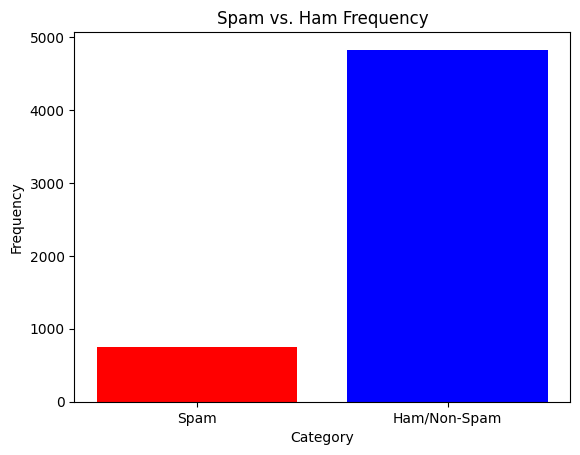

In [ ]:
import matplotlib.pyplot as plt
spam_count = df[df['v1'] == 'spam'].shape[0]
print("spam freuquency :",spam_count)
ham_count=df[df['v1'] == 'ham'].shape[0]
print("ham freuquency :", ham_count,"\n\n")


# Data for plotting
categories = ['Spam', 'Ham/Non-Spam']
counts = [spam_count, ham_count]

# Plotting the bar chart
plt.bar(categories, counts, color=['red', 'blue'])
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Spam vs. Ham Frequency')
plt.show()

# ***Data Pre-processing***

In [ ]:
import re # re is regular expression to check a input is valid or not
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Download NLTK data
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Initialize
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):

    text = text.lower()  # Lowercasing

    text = re.sub('[^a-zA-Z]', ' ', text)     # Remove punctuation and numbers

    words = nltk.word_tokenize(text)  # Tokenization

    words = [lemmatizer.lemmatize(ps.stem(word)) for word in words if word not in stop_words]  # Remove stopwords, Stemming and Lemmatization
    return ' '.join(words)

# Apply preprocessing
df['v2'] = df['v2'].apply(preprocess_text)

# Vectorization (example using TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['v2']).toarray()

# Labels
y = df['v1'].map({'spam': 1, 'ham': 0}).values

# Split into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import numpy as np

# Calculate frequencies in the training set
unique, counts = np.unique(y_train, return_counts=True)
train_freq = dict(zip(unique, counts))
print("Training Set Frequencies:", train_freq)

# Calculate frequencies in the test set
unique, counts = np.unique(y_test, return_counts=True)
test_freq = dict(zip(unique, counts))
print("Test Set Frequencies:", test_freq)

# Calculate frequencies in the validation set
unique, counts = np.unique(y_val, return_counts=True)
val_freq = dict(zip(unique, counts))
print("Validation Set Frequencies:", val_freq)


Training Set Frequencies: {0: 3860, 1: 597}
Test Set Frequencies: {0: 473, 1: 84}
Validation Set Frequencies: {0: 492, 1: 66}


# ***Feed-Forward Neural Network***

In [ ]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Classes
classes = np.unique(y_train)

class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print(class_weight_dict)


{0: 0.5773316062176166, 1: 3.7328308207705194}


In [ ]:
#FFNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(5000,)))  # Adjust input shape to match TF-IDF features
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), class_weight=class_weight_dict, batch_size=32)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               1280256   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1313281 (5.01 MB)
Trainable params: 1313281 (5.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
140/1

In [ ]:

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')


18/18 [==============================] - 0s 5ms/step - loss: 0.0942 - accuracy: 0.9785
Test Accuracy: 97.85%


18/18 [==============================] - 0s 8ms/step


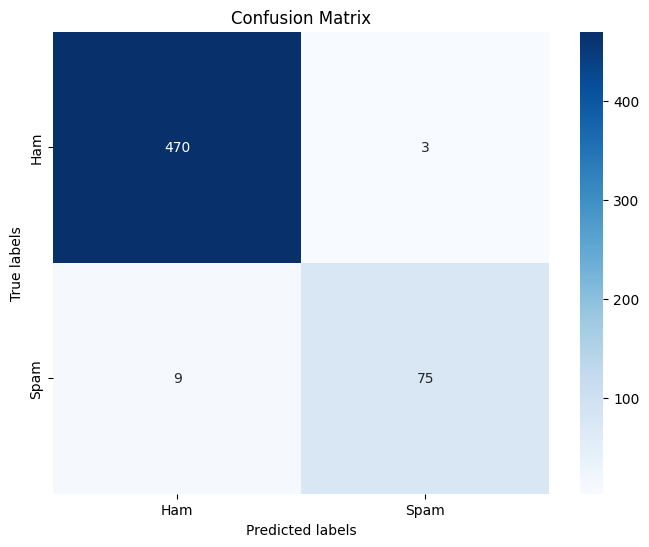

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Ham', 'Spam'])
ax.yaxis.set_ticklabels(['Ham', 'Spam'])

plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate  classification report
report = classification_report(y_test, y_pred_classes, target_names=['Ham', 'Spam'])

print(report)


              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       473
        Spam       0.96      0.89      0.93        84

    accuracy                           0.98       557
   macro avg       0.97      0.94      0.96       557
weighted avg       0.98      0.98      0.98       557



18/18 [==============================] - 0s 9ms/step


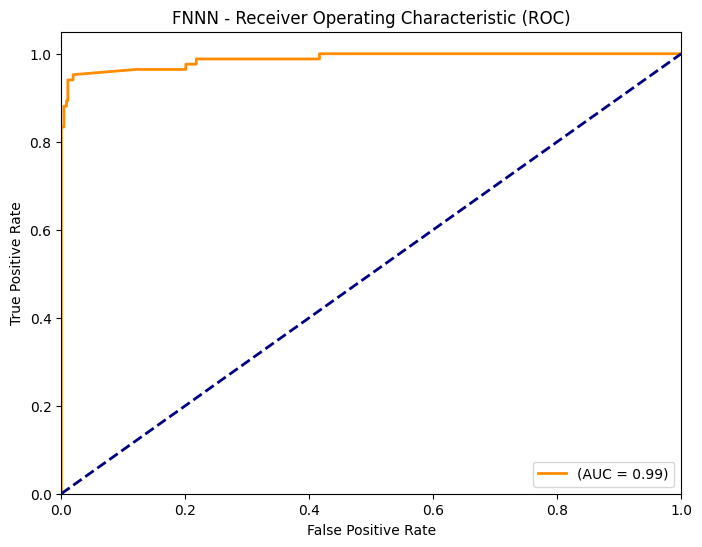

In [ ]:
#ROC-AUC
y_pred_probs = model.predict(X_test).ravel()

from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Compute ROC area under the curve
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'(AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal 45 degree line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FNNN - Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# ***Cost sensitive LSTM***

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['v2'])
sequences = tokenizer.texts_to_sequences(df['v2'])

# Pad sequences
X_seq = pad_sequences(sequences, maxlen=max_len)

# split the data again to reflect the changes
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y, test_size=0.2, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           250000    
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 341777 (1.30 MB)
Trainable params: 341777 (1.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), class_weight=class_weight_dict, batch_size=32)


Epoch 1/10
140/140 [==============================] - 50s 333ms/step - loss: 0.2788 - accuracy: 0.9190 - val_loss: 0.1355 - val_accuracy: 0.9875
Epoch 2/10
140/140 [==============================] - 40s 276ms/step - loss: 0.0721 - accuracy: 0.9897 - val_loss: 0.0661 - val_accuracy: 0.9839
Epoch 3/10
140/140 [==============================] - 37s 267ms/step - loss: 0.0277 - accuracy: 0.9962 - val_loss: 0.0621 - val_accuracy: 0.9803
Epoch 4/10
140/140 [==============================] - 40s 283ms/step - loss: 0.0173 - accuracy: 0.9964 - val_loss: 0.0463 - val_accuracy: 0.9875
Epoch 5/10
140/140 [==============================] - 39s 276ms/step - loss: 0.0103 - accuracy: 0.9982 - val_loss: 0.0444 - val_accuracy: 0.9892
Epoch 6/10
140/140 [==============================] - 36s 259ms/step - loss: 0.0065 - accuracy: 0.9984 - val_loss: 0.0497 - val_accuracy: 0.9857
Epoch 7/10
140/140 [==============================] - 38s 269ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0512 - val_ac

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

18/18 [==============================] - 1s 34ms/step - loss: 0.0620 - accuracy: 0.9838
Test Accuracy: 98.38%


18/18 [==============================] - 3s 97ms/step


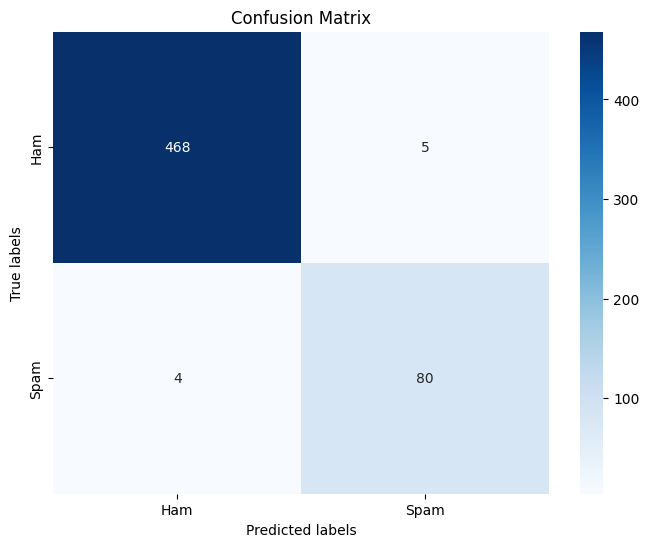

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Ham', 'Spam'])
ax.yaxis.set_ticklabels(['Ham', 'Spam'])

plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate  classification report
report = classification_report(y_test, y_pred_classes, target_names=['Ham', 'Spam'])

print(report)

              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       473
        Spam       0.94      0.95      0.95        84

    accuracy                           0.98       557
   macro avg       0.97      0.97      0.97       557
weighted avg       0.98      0.98      0.98       557



18/18 [==============================] - 0s 10ms/step


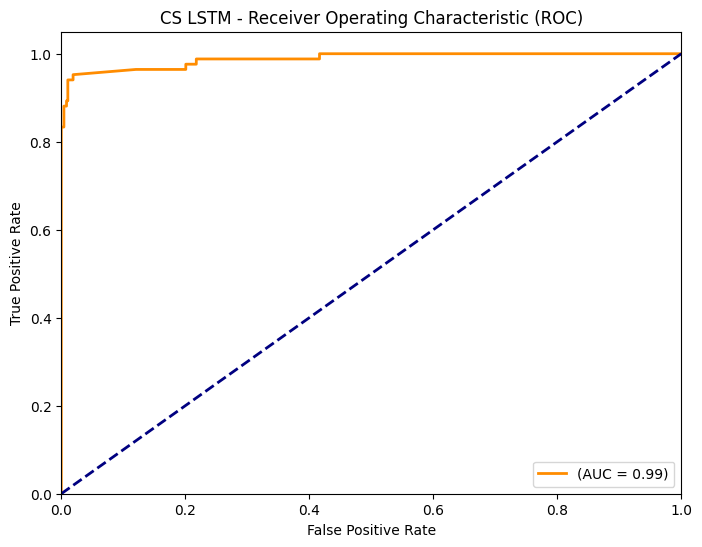

In [ ]:
##ROC-AUC
y_pred_probs = model.predict(X_test).ravel()

from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Compute ROC area under the curve
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'(AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal 45 degree line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CS LSTM - Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# ***Cost sensitive RNN***

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

# Define model parameters
max_words = 5000  # Vocabulary size
max_len = 100  # Maximum sequence length
embedding_dim = 50  # Dimension of the embedding vector

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           250000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               22912     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 273041 (1.04 MB)
Trainable params: 273041 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), class_weight=class_weight_dict, batch_size=32)


Epoch 1/10
140/140 [==============================] - 11s 65ms/step - loss: 0.4725 - accuracy: 0.7866 - val_loss: 0.0761 - val_accuracy: 0.9803
Epoch 2/10
140/140 [==============================] - 8s 60ms/step - loss: 0.1229 - accuracy: 0.9746 - val_loss: 0.0981 - val_accuracy: 0.9695
Epoch 3/10
140/140 [==============================] - 9s 67ms/step - loss: 0.0647 - accuracy: 0.9841 - val_loss: 0.0499 - val_accuracy: 0.9875
Epoch 4/10
140/140 [==============================] - 8s 58ms/step - loss: 0.0282 - accuracy: 0.9933 - val_loss: 0.0586 - val_accuracy: 0.9785
Epoch 5/10
140/140 [==============================] - 9s 63ms/step - loss: 0.0175 - accuracy: 0.9964 - val_loss: 0.0590 - val_accuracy: 0.9875
Epoch 6/10
140/140 [==============================] - 10s 70ms/step - loss: 0.0150 - accuracy: 0.9969 - val_loss: 0.0600 - val_accuracy: 0.9857
Epoch 7/10
140/140 [==============================] - 8s 57ms/step - loss: 0.0074 - accuracy: 0.9971 - val_loss: 0.0644 - val_accuracy: 0.98

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

18/18 [==============================] - 0s 11ms/step - loss: 0.0584 - accuracy: 0.9820
Test Accuracy: 98.20%


18/18 [==============================] - 0s 11ms/step


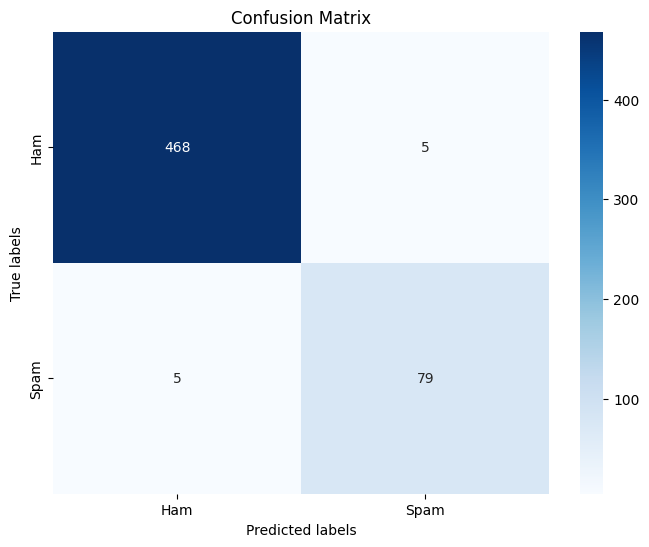

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Ham', 'Spam'])
ax.yaxis.set_ticklabels(['Ham', 'Spam'])

plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred_classes, target_names=['Ham', 'Spam'])

print(report)

              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       473
        Spam       0.94      0.94      0.94        84

    accuracy                           0.98       557
   macro avg       0.96      0.96      0.96       557
weighted avg       0.98      0.98      0.98       557



18/18 [==============================] - 0s 15ms/step


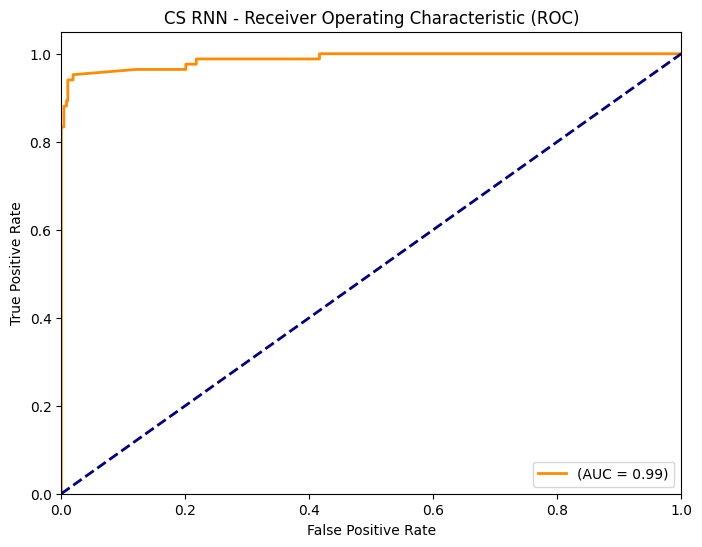

In [ ]:
#ROC-AUC
y_pred_probs = model.predict(X_test).ravel()

from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Compute ROC area under the curve
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'(AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal 45 degree line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CS RNN - Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


# ***Cost sensitive CNN***

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout

max_words = 5000
max_len = 100
embedding_dim = 50

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(Conv1D(128, 3, activation='relu')) #128 filters,kernel=3 and activation=relu

model.add(MaxPooling1D(3)) #window and stride size=3

model.add(Conv1D(128, 3, activation='relu'))

model.add(GlobalMaxPooling1D()) # Using Global Max Pooling to reduce the feature map to a single value for each feature map, helping to prevent overfitting

model.add(Dropout(0.5))  # Optional: Add a dropout layer for regularization

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 50)           250000    
                                                                 
 conv1d_5 (Conv1D)           (None, 98, 128)           19328     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 32, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 30, 128)           49280     
                                                                 
 global_max_pooling1d_3 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_6 (Dropout)         (None, 128)              

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), class_weight=class_weight_dict, batch_size=32)

Epoch 1/10
140/140 [==============================] - 5s 29ms/step - loss: 0.3631 - accuracy: 0.8174 - val_loss: 0.1389 - val_accuracy: 0.9677
Epoch 2/10
140/140 [==============================] - 4s 31ms/step - loss: 0.1139 - accuracy: 0.9785 - val_loss: 0.1388 - val_accuracy: 0.9606
Epoch 3/10
140/140 [==============================] - 3s 24ms/step - loss: 0.0553 - accuracy: 0.9908 - val_loss: 0.1205 - val_accuracy: 0.9606
Epoch 4/10
140/140 [==============================] - 3s 24ms/step - loss: 0.0374 - accuracy: 0.9957 - val_loss: 0.1079 - val_accuracy: 0.9713
Epoch 5/10
140/140 [==============================] - 5s 32ms/step - loss: 0.0311 - accuracy: 0.9966 - val_loss: 0.0823 - val_accuracy: 0.9767
Epoch 6/10
140/140 [==============================] - 4s 27ms/step - loss: 0.0262 - accuracy: 0.9980 - val_loss: 0.1049 - val_accuracy: 0.9767
Epoch 7/10
140/140 [==============================] - 3s 24ms/step - loss: 0.0208 - accuracy: 0.9984 - val_loss: 0.1171 - val_accuracy: 0.9749

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

18/18 [==============================] - 0s 14ms/step - loss: 0.0835 - accuracy: 0.9767
Test Accuracy: 97.67%


18/18 [==============================] - 0s 7ms/step


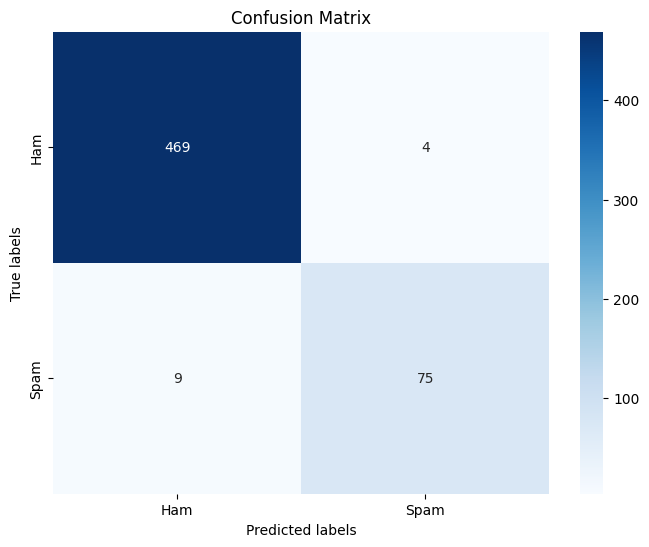

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Ham', 'Spam'])
ax.yaxis.set_ticklabels(['Ham', 'Spam'])

plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred_classes, target_names=['Ham', 'Spam'])

print(report)

              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       473
        Spam       0.95      0.89      0.92        84

    accuracy                           0.98       557
   macro avg       0.97      0.94      0.95       557
weighted avg       0.98      0.98      0.98       557



18/18 [==============================] - 0s 7ms/step


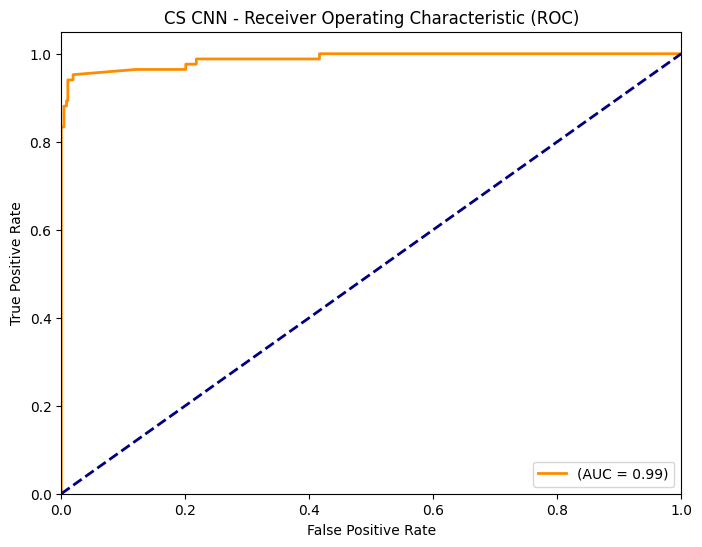

In [ ]:
#ROC-AUC
y_pred_probs = model.predict(X_test).ravel()

from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Compute ROC area under the curve
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'(AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal 45 degree line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CS CNN - Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()